##### Copyright 2019 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for experts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.18.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Use `tf.data` to batch and shuffle the dataset:

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [8]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training:

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [11]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [12]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [13]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

Epoch 1, Loss: 0.14, Accuracy: 95.95, Test Loss: 0.06, Test Accuracy: 97.97
Epoch 2, Loss: 0.04, Accuracy: 98.67, Test Loss: 0.05, Test Accuracy: 98.22
Epoch 3, Loss: 0.02, Accuracy: 99.30, Test Loss: 0.07, Test Accuracy: 98.08
Epoch 4, Loss: 0.01, Accuracy: 99.48, Test Loss: 0.06, Test Accuracy: 98.14
Epoch 5, Loss: 0.01, Accuracy: 99.68, Test Loss: 0.06, Test Accuracy: 98.36


In [14]:
# 1. High level summary
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 26, 26, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 21632)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,770,634 (10.57 MB)

 Trainable params: 2,770,634 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 2. Quick glance at the first few weight tensors
for w in model.weights[:3]:
    print(w.name, w.shape)

kernel (3, 3, 1, 32)
bias (32,)
kernel (21632, 128)


In [16]:
# 3. Zoom in on one layer
dense1 = model.layers[0]        # index or use .get_layer("dense") if you named it
kernel, bias = dense1.get_weights()
print("Kernel stats", kernel.mean(), kernel.std())
print("Bias stats", bias.mean(), bias.std())

Kernel stats -0.027504401 0.19162536
Bias stats -0.07693009 0.06035683


In [17]:
# 3. Zoom in on one layer
dense1 = model.layers[0]        # index or use .get_layer("dense") if you named it
kernel, bias = dense1.get_weights()
print("Kernel stats", kernel.mean(), kernel.std())
print("Bias stats", bias.mean(), bias.std())

Kernel stats -0.027504401 0.19162536
Bias stats -0.07693009 0.06035683


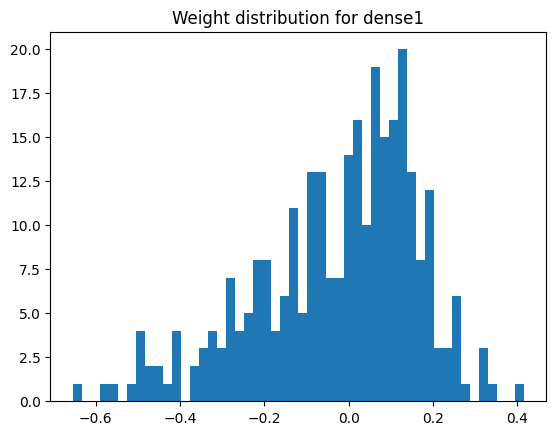

In [18]:
# 4. Visual sanity check (optional)
import matplotlib.pyplot as plt
plt.hist(kernel.flatten(), bins=50)
plt.title("Weight distribution for dense1")
plt.show()

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

In [19]:
# Get the input shape from a batch of images
for images, labels in train_ds.take(1):
  input_shape = images.shape
  break

# Create a dummy input tensor with the correct shape
dummy_input = tf.zeros(input_shape)

# Pass the dummy input through the first layer to get its output
layer = model.layers[0]
output_tensor = layer(dummy_input)

# Now you can access the shape of the output tensor
print(layer.name)
print(output_tensor.shape)

conv2d
(32, 26, 26, 32)


In [20]:
!pip install transformers

In [21]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Analyze the sentiment of a sample text
text = "I love using Google Colab, it's so convenient!"
result = sentiment_analyzer(text)

# Print the result
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9984538555145264}]


In [22]:
from transformers import pipeline

# Load the Named Entity Recognition pipeline
ner_recognizer = pipeline("ner", grouped_entities=True)

# Analyze a sample text for named entities
text = "Google was founded by Larry Page and Sergey Brin in 1998."
results = ner_recognizer(text)

# Print the results
print(results)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cuda:0


[{'entity_group': 'ORG', 'score': np.float32(0.99876714), 'word': 'Google', 'start': 0, 'end': 6}, {'entity_group': 'PER', 'score': np.float32(0.9988831), 'word': 'Larry Page', 'start': 22, 'end': 32}, {'entity_group': 'PER', 'score': np.float32(0.99473953), 'word': 'Sergey Brin', 'start': 37, 'end': 48}]


In [23]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# Use a newer, smaller model that is likely to work
pipe = pipeline("text-generation", model="distilgpt2")

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
# Define a prompt
prompt = "Write a short story about a robot learning to feel."

# Generate text using the loaded pipeline
# You can adjust max_length to control the length of the generated text
generated_text = pipe(prompt, max_length=200, num_return_sequences=1)

# Print the generated text
print(generated_text[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Write a short story about a robot learning to feel.


































































































































































































































































In [25]:
!pip install pymupdf

In [26]:
import fitz # PyMuPDF

pdf_path = "/content/Designing a Programming Knowledge Graph with Transformers.pdf"
doc = fitz.open(pdf_path)
text = ""
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text += page.get_text()

print(text[:1000]) # Print the first 1000 characters to check

Designing a Programming Knowledge 
Graph with Transformers 
Introduction and Project Overview 
Building a high-performance text analysis platform for programming knowledge requires a 
modular pipeline that can ingest diverse documentation, extract structured facts, and integrate 
them into a knowledge graph. The objective is to advance an AI assistant’s Logic Storage and 
Reasoning by capturing programming knowledge (languages, libraries, APIs, algorithms, design 
patterns, etc.) from unstructured text. We propose a pipeline that: (a) ingests multi-format docs 
and cleans them, (b) applies state-of-the-art Hugging Face Transformer models for entity 
extraction, relation extraction, and text classification, and (c) constructs an evolving 
knowledge graph for querying and reasoning. Crucially, we focus on open-source models and 
tools for reproducibility and scalability. Below, we detail each component of the system and 
outline best practices (e.g. corpus selection, model choices, infra

In [27]:
# Apply NER to the extracted text from the PDF
# We'll process the text in chunks if it's very long
chunk_size = 500 # Process in chunks of 500 characters
entities = []
for i in range(0, len(text), chunk_size):
    chunk = text[i:i+chunk_size]
    chunk_entities = ner_recognizer(chunk)
    entities.extend(chunk_entities)

# Print the first 20 identified entities as an example
print("First 20 identified entities:")
for entity in entities[:20]:
    print(entity)

# You can explore the full 'entities' list to see all identified entities

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


First 20 identified entities:
{'entity_group': 'ORG', 'score': np.float32(0.8192535), 'word': 'Transformers', 'start': 46, 'end': 58}
{'entity_group': 'MISC', 'score': np.float32(0.7187696), 'word': 'Hu', 'start': 114, 'end': 116}
{'entity_group': 'MISC', 'score': np.float32(0.5638208), 'word': 'Face Transformer', 'start': 122, 'end': 138}
{'entity_group': 'MISC', 'score': np.float32(0.88017505), 'word': 'Python', 'start': 378, 'end': 384}
{'entity_group': 'MISC', 'score': np.float32(0.97236896), 'word': 'JavaScript', 'start': 386, 'end': 396}
{'entity_group': 'MISC', 'score': np.float32(0.93952066), 'word': 'Java', 'start': 399, 'end': 403}
{'entity_group': 'MISC', 'score': np.float32(0.8166788), 'word': 'Face', 'start': 184, 'end': 188}
{'entity_group': 'MISC', 'score': np.float32(0.89480287), 'word': 'NL', 'start': 200, 'end': 202}
{'entity_group': 'MISC', 'score': np.float32(0.9729169), 'word': 'Python', 'start': 422, 'end': 428}
{'entity_group': 'MISC', 'score': np.float32(0.71370